## 1. Installation et import des librairies

In [ ]:
!pip install flaml dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from flaml import AutoML

## 2. Chargement et préparation des données

Nous allons utiliser le jeu de données Iris, disponible via sklearn.datasets. Il s’agit d’un jeu de données classique comportant 150 échantillons de fleurs Iris, réparties en trois classes (Iris setosa, Iris versicolor, Iris virginica).

In [ ]:
# Chargement du dataset Iris
iris = load_iris()
X = iris.data
y = iris.target

# Transformation en DataFrame pour une visualisation plus aisée
df_iris = pd.DataFrame(data=X, columns=iris.feature_names)
df_iris['target'] = y

# Affichage des 5 premières lignes
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Vous pouvez observer les quatre caractéristiques (longueur et largeur des sépales, longueur et largeur des pétales) dans les colonnes, ainsi que la classe cible (target).

### Séparation en ensemble d’entraînement et de test

Nous allons séparer les données en deux ensembles : entraînement (train) et test, dans un ratio de 80 % / 20 % par exemple.

In [ ]:
# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Taille de l'ensemble d'entraînement :", X_train.shape)
print("Taille de l'ensemble de test :", X_test.shape)

Taille de l'ensemble d'entraînement : (120, 4)
Taille de l'ensemble de test : (30, 4)


## 3. Configuration et entraînement du modèle AutoML avec FLAML

L’AutoML de FLAML se charge de trouver automatiquement le meilleur modèle et les meilleurs hyperparamètres possibles pour notre problème de classification, en fonction de la contrainte de temps que nous allons spécifier (par exemple, 60 secondes).

Pendant l’exécution, FLAML va explorer différents algorithmes (RF, XGBoost, LightGBM, etc.) et différents hyperparamètres pour optimiser l’exactitude (accuracy) du modèle.

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # ignore tous les warnings Python

# Instanciation de l'objet AutoML
automl = AutoML()

# Définition des paramètres pour FLAML
settings = {
    "time_budget": 60,
    "metric": "accuracy",
    "task": "classification",
    "log_file_name": None,  # Pas de fichier de log
    "log_type": "none",     # Pas de log dans la console
    "verbose": 0,           # Niveau de verbosité minimal
    "seed": 42
}

# Entraînement
automl.fit(X_train, y_train, **settings)

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


## 4. Évaluation du meilleur modèle

Une fois l’apprentissage terminé, on peut examiner le meilleur modèle trouvé et son score sur le jeu de test.

In [ ]:
# Meilleur modèle
print("Meilleur estimateur :", automl.best_estimator)
print("Meilleure configuration :", automl.best_config)
print("Meilleur score validé :", automl.best_loss)  # perte calculée sur la validation interne de FLAML

# Prédictions sur le jeu de test
y_pred = automl.predict(X_test)

# Calcul de l'accuracy sur le jeu de test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sur le jeu de test :", accuracy)

Meilleur estimateur : xgboost
Meilleure configuration : {'n_estimators': 6, 'max_leaves': 5, 'min_child_weight': 1.8828411897474473, 'learning_rate': 0.13744077928924925, 'subsample': 0.8856572673236026, 'colsample_bylevel': 0.9603236631907518, 'colsample_bytree': 0.8772863122974667, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.8386514121849542}
Meilleur score validé : 0.04166666666666665
Accuracy sur le jeu de test : 1.0


## 5. Visualisation de la matrice de confusion

Pour mieux comprendre les erreurs commises par le modèle, on peut visualiser la matrice de confusion :

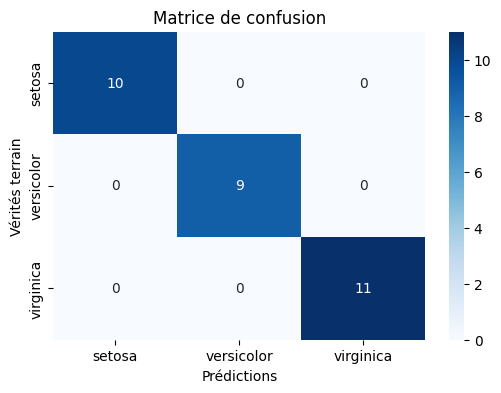

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.show()

## 6. Conclusion et pistes d’exploration

*	Conclusion : FLAML a automatiquement trouvé un modèle performant pour la classification des fleurs Iris, sans que nous ayons à passer du temps sur l’optimisation manuelle des hyperparamètres.
*	Pistes d’exploration :
	1.	Modifier le time_budget pour comparer les performances en fonction du temps alloué.
	2.	Changer la métrique à optimiser (ex. f1 au lieu de accuracy).
	3.	Tester le modèle sur d’autres jeux de données (ex. Wine, Breast Cancer).
	4.	Explorer plus en détail les logs (fichier .log) pour comprendre les essais d’hyperparamètres réalisés par FLAML.

Vous avez ainsi un exemple d’exercice simple illustrant l’usage de FLAML pour une tâche de classification, ici sur le dataset Iris. Le grand avantage d’AutoML est de réduire le temps et l’expertise nécessaires pour trouver un modèle compétitif, en automatisant le choix de l’algorithme et de ses hyperparamètres.